>### 🚩 *Create a free WhyLabs account to get more value out of whylogs!*<br> 
>*Did you know you can store, visualize, and monitor whylogs profiles with the [WhyLabs Observability Platform](https://whylabs.ai/whylogs-free-signup?utm_source=whylogs-Github&utm_medium=whylogs-example&utm_campaign=Validation_Tutorial)? Sign up for a [free WhyLabs account](https://whylabs.ai/whylogs-free-signup?utm_source=whylogs-Github&utm_medium=whylogs-example&utm_campaign=Validation_Tutorial) to leverage the power of whylogs and WhyLabs together!*

# Data Validation at Scale - Detecting and Responding to Data Misbehavior

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/whylabs/whylogs/blob/mainline/python/examples/tutorials/Data_Validation_Tutorial.ipynb)

In this tutorial, we'll introduce the concept of data logging and discuss how to validate data at scale by creating metric constraints and generating reports based on the data's statistical profiles using the whylogs open-source package.

We will also walk through steps that data scientists and ML engineers can take to tailor their set of validations to fit the specific needs of their business or project, take actions when their rules fail to be met, and debug and troubleshoot cases where data fails to behave as expected.

## Agenda
- Session 1: Introduction to Data Logging with whylogs
- Session 2: Data Validation with Metric Constraints
- Session 3: Per-value constraints with Condition Count Metrics
- Session 4: Auto-constraints generation
- Session 5: Debugging Failed Conditions

## What is Data Validation?

Data validation is the process of ensuring that data is accurate, complete, and consistent. It involves checking data for errors or inconsistencies, and ensuring that it meets the specified requirements or constraints. Data validation is important because it helps to ensure the integrity and quality of data, and helps to prevent errors or inaccuracies in data from propagating and causing problems downstream.

In whylogs, you validate data by creating Metric Constraints and validating those constraints against a whylogs profile.


# Session  1 - Data Logging

## Installing whylogs

To install the whylogs library, you can use the following command:

In [ ]:
%pip install -q 'whylogs[viz]'

## Loading a Pandas DataFrame

Before showing how we can log data, we first need the data itself. Let's create a simple Pandas DataFrame:


In [1]:
import pandas as pd
data = {
    "animal": ["cat", "hawk", "snake", "cat"],
    "legs": [4, 2, 0, 4],
    "weight": [4.3, 1.8, 1.3, 4.1],
}

df = pd.DataFrame(data)

## Profiling with whylogs

To obtain a profile of your data, you can simply use whylogs' `log` call, and navigate through the result to a specific profile with `profile()`:

In [2]:
import whylogs as why

profile = why.log(df).profile()

## Analyzing Profiles

Once you're done logging the data, you can generate a Profile View and inspect it in a Pandas Dataframe format:

In [3]:
profile_view = profile.view()
prof_df = profile_view.to_pandas()

prof_df

,cardinality/est,cardinality/lower_1,cardinality/upper_1,counts/inf,counts/n,counts/nan,counts/null,distribution/max,distribution/mean,distribution/median,...,frequent_items/frequent_strings,type,types/boolean,types/fractional,types/integral,types/object,types/string,types/tensor,ints/max,ints/min
column,,,,,,,,,,,,,,,,,,,,,
animal,3.0,3.0,3.00015,0,4,0,0,NaN,0.000,NaN,...,"[FrequentItem(value='cat', est=2, upper=2, low...",SummaryType.COLUMN,0,0,0,0,4,0,NaN,NaN
legs,3.0,3.0,3.00015,0,4,0,0,4.0,2.500,4.0,...,"[FrequentItem(value='4', est=2, upper=2, lower...",SummaryType.COLUMN,0,0,4,0,0,0,4.0,0.0
weight,4.0,4.0,4.00020,0,4,0,0,4.3,2.875,4.1,...,NaN,SummaryType.COLUMN,0,4,0,0,0,0,NaN,NaN


This will provide you with valuable statistics on a column (feature) basis, such as:

- Counters, such as number of samples and null values
- Inferred types, such as integral, fractional and boolean
- Estimated Cardinality
- Frequent Items
- Distribution Metrics: min,max, median, quantile values

In [4]:
merged_profile_view = profile_view.merge(profile_view)
merged_profile_view.to_pandas()

,cardinality/est,cardinality/lower_1,cardinality/upper_1,counts/inf,counts/n,counts/nan,counts/null,distribution/max,distribution/mean,distribution/median,...,frequent_items/frequent_strings,type,types/boolean,types/fractional,types/integral,types/object,types/string,types/tensor,ints/max,ints/min
column,,,,,,,,,,,,,,,,,,,,,
animal,3.0,3.0,3.00015,0,8,0,0,NaN,0.000,NaN,...,"[FrequentItem(value='cat', est=4, upper=4, low...",SummaryType.COLUMN,0,0,0,0,8,0,NaN,NaN
legs,3.0,3.0,3.00015,0,8,0,0,4.0,2.500,4.0,...,"[FrequentItem(value='4', est=4, upper=4, lower...",SummaryType.COLUMN,0,0,8,0,0,0,4.0,0.0
weight,4.0,4.0,4.00020,0,8,0,0,4.3,2.875,4.1,...,NaN,SummaryType.COLUMN,0,8,0,0,0,0,NaN,NaN


## Writing to Disk
You can also store your profile in disk for further inspection:

In [5]:
why.write(profile,"profile.bin")

(True, 'profile.bin')

## Reading from Disk

You can read the profile back into memory with:

In [6]:
n_prof = why.read("profile.bin")

# Session 2 - Data Validation with Metric Constraints

Constraints are a powerful feature built on top of whylogs profiles that enable you to quickly and easily validate that your data looks the way that it should. There are numerous types of constraints that you can set on your data (that numerical data will always fall within a certain range, that text data will always be in a JSON format, etc) and, if your dataset fails to satisfy a constraint, you can fail your unit tests or your data pipeline.

You can create Metric Constraints in two different ways:

- By directly using out-of-the-box helper constraints, such as greater_than_number, no_missing_values, or is_non_negative.
- By assembling your own set of tailored constraints.
- By automatically generating constraints from a reference profile

Once you have a set of constraints, you can use it to validate or generate a report of a Profile.

In this session, we'll show how to create constraints through the first approach: by using out-of-the-box helper constraints.


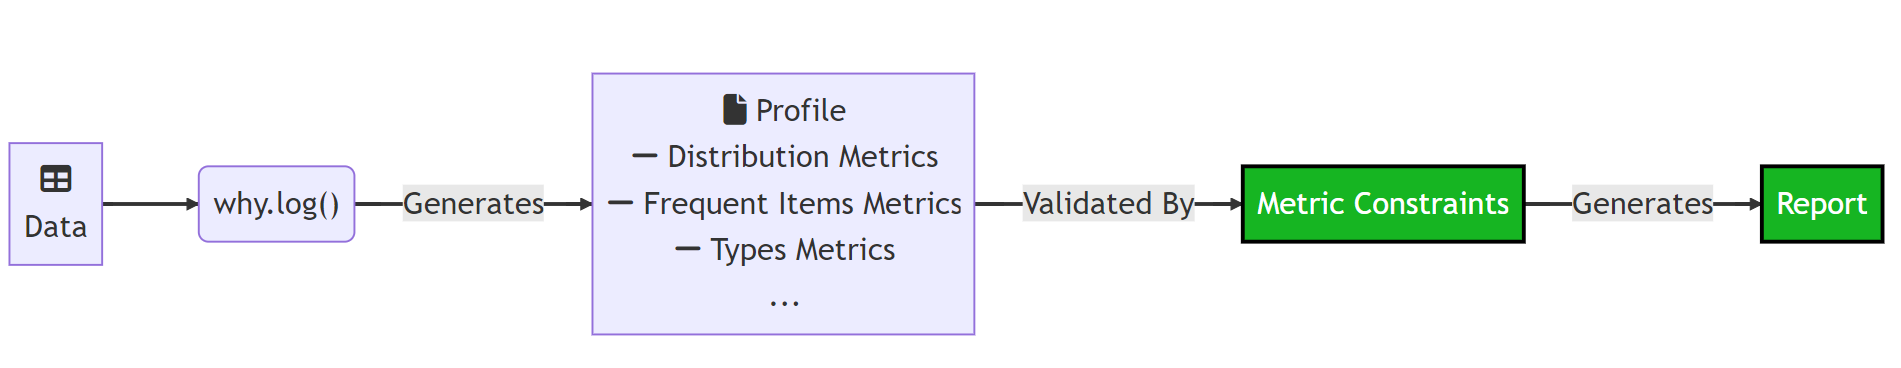

The above diagram depicts the relationship between the concepts presented so far:

As its name suggest, a metric constraint uses metrics in a profile to perform the validation. With no additional customization, the constraint will have at its disposal standard metrics captured in the logging process, such as Distribution, Frequent Items and Cardinality metrics.

## Loading the Data

To begin, let's load the data into our environment. We will be using two datasets: df_reference and df_target.

We will create our set of constraints assuming the existence of previous domain knowledge and experience with the data. We will use `df_reference` as our reference dataset to create the constraints, and `df_target` as the dataset to be validated. In an ML scenario, `df_reference` will usually be the training dataset, and `df_target` the data you encounter in production on the system's day-to-day operation.

In [7]:
import pandas as pd

df_reference = pd.read_parquet("https://whylabs-public.s3.us-west-2.amazonaws.com/whylogs_examples/Listings/airbnb_listings_reference.parquet")
df_target = pd.read_parquet("https://whylabs-public.s3.us-west-2.amazonaws.com/whylogs_examples/Listings/airbnb_listings_target.parquet")

In [8]:
df_reference.head(2)

,name,description,listing_url,last_review,number_of_reviews_ltm,number_of_reviews_l30d,id,latitude,longitude,availability_365,bedrooms,reviews_per_month,room_type,price
17895,COPACABANA PRINCESINHA DO MAR,na quadra da praia. pertinho da pedra do leme....,https://www.airbnb.com/rooms/37994848,2020-02-22,2,0,37994848,-22.96576,-43.17784,82,1,0.44,Entire home/apt,220.0
5343,*Double Room with A/C & TV – Riocentro,Welcome to Rio de Janeiro-Gated community loca...,https://www.airbnb.com/rooms/10123238,2016-08-23,0,0,10123238,-22.95001,-43.38205,0,1,0.02,Private room,119.0


## Defining the Constraints

Let's define a list of constraints to apply to our data in the tables below.

For each of these constraints, we will show the feature it will be applied to, used parameters, and also a brief explanation of what it checks for.

### Completeness Constraints

| constraint  | feature | parameters  | semantic                                        |
|-------------|---------|-------------|-------------------------------------------------|
| no_missing_values | id      | column name | Checks that are no missing values in the column |


### Consistency Constraints

| constraint                        | feature               | parameters                         | semantic                                                                    |
|-----------------------------------|-----------------------|------------------------------------|-----------------------------------------------------------------------------|
| is_probably_unique                         | _id_                  | column name                        | Checks that there are probably no duplicate values in a column.                      |
| matches_pattern                   | _listing_url_         | column name, regex pattern         | Checks that all values match regex pattern (if link is from airbnb domain)  |
| is_in_range                       | _latitude, longitude_ | column name, lower and upper bound | Checks that column is inside a range defined by a lower and upper bound     |
| is_less_than                      | _availability_365_    | column name, value                 | Checks that maximum value of column is less than number                     |
| is_nullable_integral            | _bedrooms_            | column name                        | Checks that column contains only integral values (null values acceptable) |
| is_nullable_fractional            | _price_            | column name                        | Checks that column contains only fractional values (null values acceptable) |
| is_non_negative                   | _bedrooms_            | column name                        | Checks that column contains only non negative values                        |
| matches_date_format               | _last_review_         | column name, date pattern          | Checks that all values match date pattern (Y-m-d)                           |
| frequent_strings_on_reference_set | _room_type_           | column name, reference set         | Checks that all values are in reference set                                 |


### Statistics Constraints

| constraint           | feature             | parameters                          | semantic                                                                               |
|----------------------|---------------------|-------------------------------------|----------------------------------------------------------------------------------------|
| quantile_between_range            | _price_            | column name, quantile, lower, upper                       | Checks that Q-th quantile value must be withing the range defined |


In [9]:
df_reference['room_type'].value_counts()

Entire home/apt    8725
Private room       2902
Shared room         208
Hotel room           68
Name: room_type, dtype: int64

## Profiling and Building the Constraints

To build our constraints, let's first profile our target dataset:

In [10]:
import whylogs as why

target_profile = why.log(df_target).view()

Now, we create our constraints with the help of `ConstraintsBuilder`. That will allow us to iterate over the constraints we wish to build. Let's first show how to add a single constraint. Let's begin with the `no_missing_values` constraint for the `id` feature:

In [11]:
from whylogs.core.constraints.factories import no_missing_values
from whylogs.core.constraints import ConstraintsBuilder

builder = ConstraintsBuilder(dataset_profile_view=target_profile)

builder.add_constraint(no_missing_values(column_name="id"))

constraints = builder.build()


constraints.generate_constraints_report()

[ReportResult(name='id has no missing values', passed=1, failed=0, summary=None)]

Now, we can call `constraints.validate` to validate our constraints against the target profile:

In [12]:
constraints.validate()

True

`validate` will return True if all the constraints passes, and False otherwise. In this case, we can see that the constraint passes, as there are no missing values in the `id` column.

We can also call `generate_constraints_report` to generate a report of the constraints against the target profile:

In [13]:
constraints.generate_constraints_report()

[ReportResult(name='id has no missing values', passed=1, failed=0, summary=None)]

Let's continue adding constraints as defined previously:

In [14]:
from whylogs.core.constraints.factories import column_is_probably_unique
from whylogs.core.constraints.factories import is_in_range
from whylogs.core.constraints.factories import smaller_than_number
from whylogs.core.constraints.factories import quantile_between_range
from whylogs.core.constraints.factories import is_non_negative
from whylogs.core.constraints.factories import frequent_strings_in_reference_set
from whylogs.core.constraints.factories import column_is_nullable_integral, column_is_nullable_fractional

room_set = {'Private room', 'Shared room', 'Hotel room', 'Entire home/apt'}

builder.add_constraint(column_is_probably_unique(column_name="id"))
builder.add_constraint(is_in_range(column_name="latitude",lower=-24,upper=-22))
builder.add_constraint(is_in_range(column_name="longitude",lower=-44,upper=-43))
builder.add_constraint(smaller_than_number(column_name="availability_365",number=366))
builder.add_constraint(quantile_between_range(column_name="price",quantile=0.5,lower=150,upper=437))
builder.add_constraint(is_non_negative(column_name="bedrooms"))
builder.add_constraint(column_is_nullable_integral(column_name="bedrooms"))
builder.add_constraint(column_is_nullable_fractional(column_name="price"))
builder.add_constraint(frequent_strings_in_reference_set(column_name="room_type",reference_set=room_set))
constraints = builder.build()

constraints.generate_constraints_report()

[ReportResult(name='id has no missing values', passed=1, failed=0, summary=None),
 ReportResult(name='latitude is in range [-24,-22]', passed=1, failed=0, summary=None),
 ReportResult(name='longitude is in range [-44,-43]', passed=1, failed=0, summary=None),
 ReportResult(name='availability_365 smaller than number 366', passed=1, failed=0, summary=None),
 ReportResult(name='price 0.5-th quantile value between 150 and 437 (inclusive)', passed=1, failed=0, summary=None),
 ReportResult(name='price is nullable fractional', passed=1, failed=0, summary=None),
 ReportResult(name='bedrooms is non negative', passed=1, failed=0, summary=None),
 ReportResult(name='bedrooms is nullable integral', passed=0, failed=1, summary=None),
 ReportResult(name="room_type values in set {'Entire home/apt', 'Hotel room', 'Shared room', 'Private room'}", passed=1, failed=0, summary=None),
 ReportResult(name='id is probably unique', passed=0, failed=1, summary=None)]

We can also visualize the constraints report with the `viz` module. With it, you can filter the displayed constraints by name or status (pass or fail).

If you hover on each constraint's status, it will provide you with additional context that was used to determine the constraint's status.

In [15]:
from whylogs.viz import NotebookProfileVisualizer

visualization = NotebookProfileVisualizer()
visualization.constraints_report(constraints, cell_height=300)

# Session 3 - Per-value constraints with Condition Count Metrics

whylogs profiles contain summarized information about our data. This means that it’s a lossy process, and once we get the profiles, we don’t have access anymore to the complete set of data.

This makes it impossible to create some types of constraints from the standard metrics themselves. For example, suppose you need to check every row of a column to verify that there is no textual information that matches a credit card number or email information. Or maybe you’re interested in ensuring that there are no even numbers in a certain column. How do we do that if we don’t have access to the complete data?

The answer is that you need to define a Condition Count Metric to be tracked before logging your data. This metric will count the number of times the values of a given column meet a user-defined condition. When the profile is generated, you’ll have that information to check against the constraints you’ll create.

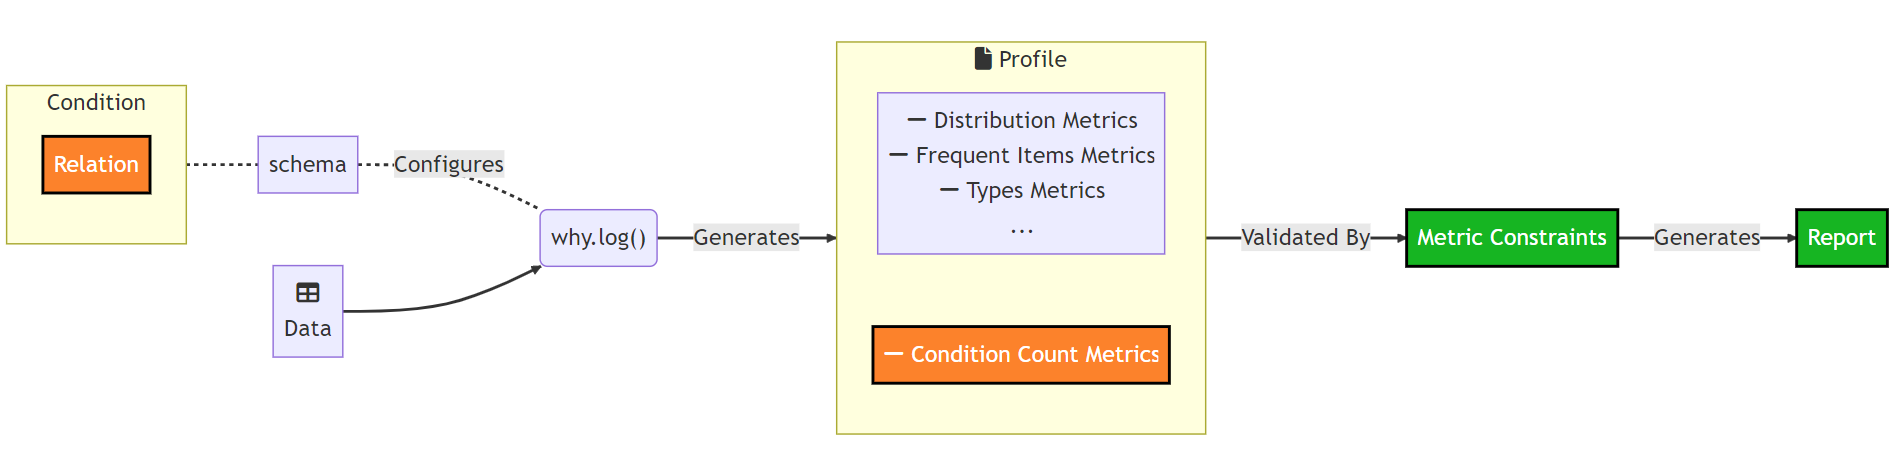

- A whylogs __profile__ contains a set of metrics that summarize the original data. 
- __Metric Constraints__ validate __Metrics__ present on the __Profile__ to generate a Report. This report will tell us whether the data meets the data quality constraints we defined.
- Those metrics can be standard metrics, such as Distribution, Frequent Items, or Types metrics. They can also be __Condition Count Metrics__.
- Condition Count Metrics count the number of times a certain relation passed/failed. For example, the number of times the rows for the column `Name` was equal to `Bob`
- For a profile to contain Condition Count Metrics, you first have to specify a Condition __before__ logging your data, and pass that to your Dataset Schema.
- The Dataset Schema configures the behavior for tracking metrics in whylogs.


## Defining the Conditions

The conditions are defined through a whylogs' `Condition` object. There are several different ways of assembling a condition. In the following example, we will define a custom function that will verify if the string is properly formatted as a date. We'll also define a second relation that will validate the text against a defined regex pattern to verify the url formatting.

Since we can define multiple conditions for a single column, we'll assemble the conditions into dictionaries, where the key is the condition name. Each dictionary will later be attached to the relevant column.

In [16]:
import datetime
from whylogs.core.relations import Predicate
from typing import Any
from whylogs.core.metrics.condition_count_metric import Condition

def date_format(x: Any) -> bool:
    date_format = '%Y-%m-%d'
    if x is None:
        return True
    try:
        datetime.datetime.strptime(x, date_format)
        return True
    except ValueError:
        return False
        

last_review_conditions = {"is_date_format": Condition(Predicate().is_(date_format))}
listing_url_conditions = {"url_matches_airbnb_domain": Condition(Predicate().matches("^https:\/\/www.airbnb.com\/rooms"))}

### Creating the Schema and Logging the Data

whylogs must be aware of those conditions while profiling the data. We can do that by creating a Standard Schema, and then simply adding the conditions to the schema with `add_resolver_spec`. That way, we can pass our enhanced schema when calling `why.log()` later.

In [17]:
from whylogs.core.schema import DeclarativeSchema
from whylogs.core.resolvers import STANDARD_RESOLVER
from whylogs.core.specialized_resolvers import ConditionCountMetricSpec

schema = DeclarativeSchema(STANDARD_RESOLVER)

schema.add_resolver_spec(column_name="last_review", metrics=[ConditionCountMetricSpec(last_review_conditions)])
schema.add_resolver_spec(column_name="listing_url", metrics=[ConditionCountMetricSpec(listing_url_conditions)])

In [18]:
import whylogs as why
target_profile = why.log(df_target, schema=schema).view()

### Generating constraints

In [19]:
from whylogs.core.constraints.factories import condition_meets
from whylogs.core.constraints import ConstraintsBuilder

builder = ConstraintsBuilder(dataset_profile_view=target_profile)

room_set = {'Private room', 'Shared room', 'Hotel room', 'Entire home/apt'}

builder.add_constraint(no_missing_values(column_name="id"))
builder.add_constraint(column_is_probably_unique(column_name="id"))
builder.add_constraint(is_in_range(column_name="latitude",lower=-24,upper=-22))
builder.add_constraint(is_in_range(column_name="longitude",lower=-44,upper=-43))
builder.add_constraint(smaller_than_number(column_name="availability_365",number=366))
builder.add_constraint(quantile_between_range(column_name="price",quantile=0.5,lower=150,upper=437))
builder.add_constraint(is_non_negative(column_name="bedrooms"))
builder.add_constraint(column_is_nullable_integral(column_name="bedrooms"))
builder.add_constraint(column_is_nullable_fractional(column_name="price"))
builder.add_constraint(frequent_strings_in_reference_set(column_name="room_type",reference_set=room_set))

builder.add_constraint(condition_meets(column_name="last_review", condition_name="is_date_format"))
builder.add_constraint(condition_meets(column_name="listing_url", condition_name="url_matches_airbnb_domain"))


constraints = builder.build()
constraints.generate_constraints_report()

[ReportResult(name='id has no missing values', passed=1, failed=0, summary=None),
 ReportResult(name='latitude is in range [-24,-22]', passed=1, failed=0, summary=None),
 ReportResult(name='longitude is in range [-44,-43]', passed=1, failed=0, summary=None),
 ReportResult(name='availability_365 smaller than number 366', passed=1, failed=0, summary=None),
 ReportResult(name='price 0.5-th quantile value between 150 and 437 (inclusive)', passed=1, failed=0, summary=None),
 ReportResult(name='price is nullable fractional', passed=1, failed=0, summary=None),
 ReportResult(name='bedrooms is non negative', passed=1, failed=0, summary=None),
 ReportResult(name='bedrooms is nullable integral', passed=0, failed=1, summary=None),
 ReportResult(name="room_type values in set {'Entire home/apt', 'Hotel room', 'Shared room', 'Private room'}", passed=1, failed=0, summary=None),
 ReportResult(name='last_review meets condition is_date_format', passed=0, failed=1, summary=None),
 ReportResult(name='listi

In [20]:
from whylogs.viz import NotebookProfileVisualizer

visualization = NotebookProfileVisualizer()
visualization.constraints_report(constraints, cell_height=300)

# Session 4 (Bonus) - Constraints Auto Generation

Constraints can be built:
1. From domain knowledge
2. Based on a Reference Dataset

Until now, we have demonstrated how to build constraints based on the user's experience and knowledge about the data. Another way to get us started is by automatically generating a set of constraints based on a __Reference Profile__. This is useful when we have a dataset that we know is of good quality, and we want to ensure that future data is similar to it.

Let's do it all on one block: We will ask for suggested constraints based on a reference profile with `generate_constraints_from_reference_profile`, and then we will validate those constraints against our target profile. Then, we will visualize our constraints report by calling `constraints_report`:

In [21]:
from whylogs.experimental.constraints_generation import (
    generate_constraints_from_reference_profile,
)
from whylogs.core.constraints import ConstraintsBuilder
import whylogs as why

target_profile = why.log(df_target, schema=schema).view()
reference_profile = why.log(df_reference, schema=schema).view()

suggested_constraints = generate_constraints_from_reference_profile(reference_profile_view=reference_profile)

builder = ConstraintsBuilder(dataset_profile_view=target_profile)
builder.add_constraints(suggested_constraints)
constraints = builder.build()

from whylogs.viz import NotebookProfileVisualizer

visualization = NotebookProfileVisualizer()
visualization.constraints_report(constraints)

> Note. The constraints generated by `generate_constraints_from_reference_profile` are not guaranteed to be the best constraints for your data. They are just a starting point. You should always review the constraints and adjust them to your needs. The feature is also currently experimental, and we are working on improving it.

## Session 5 - Debugging Failed Conditions

With __Condition Validators__, the user is able to evaluate conditions on individual values on real-time scenarios. These checks are done while data is being logged, and can trigger one or multiple actions when these conditions fail to be met. With __Condition Validators__, you are able to define actions where an immediate response is required, such as emiting an alert to key stakeholders, logging specific failures or throwing exceptions. Validators are designed with flexibility in mind, so you are free to customize your actions as well as the conditions that trigger those actions.

Unlike metrics, validators will not log properties into profiles. They are meant only to evaluate conditions and trigger actions while logging is under way.

Additionally, the validator retain contextual information about the data that failed the conditions. This is done through the process of __Reservoir Sampling__. This means that the validator will retain a sample of the data that failed the conditions, and will be able to provide that information when the user requests it.

### Data Validators

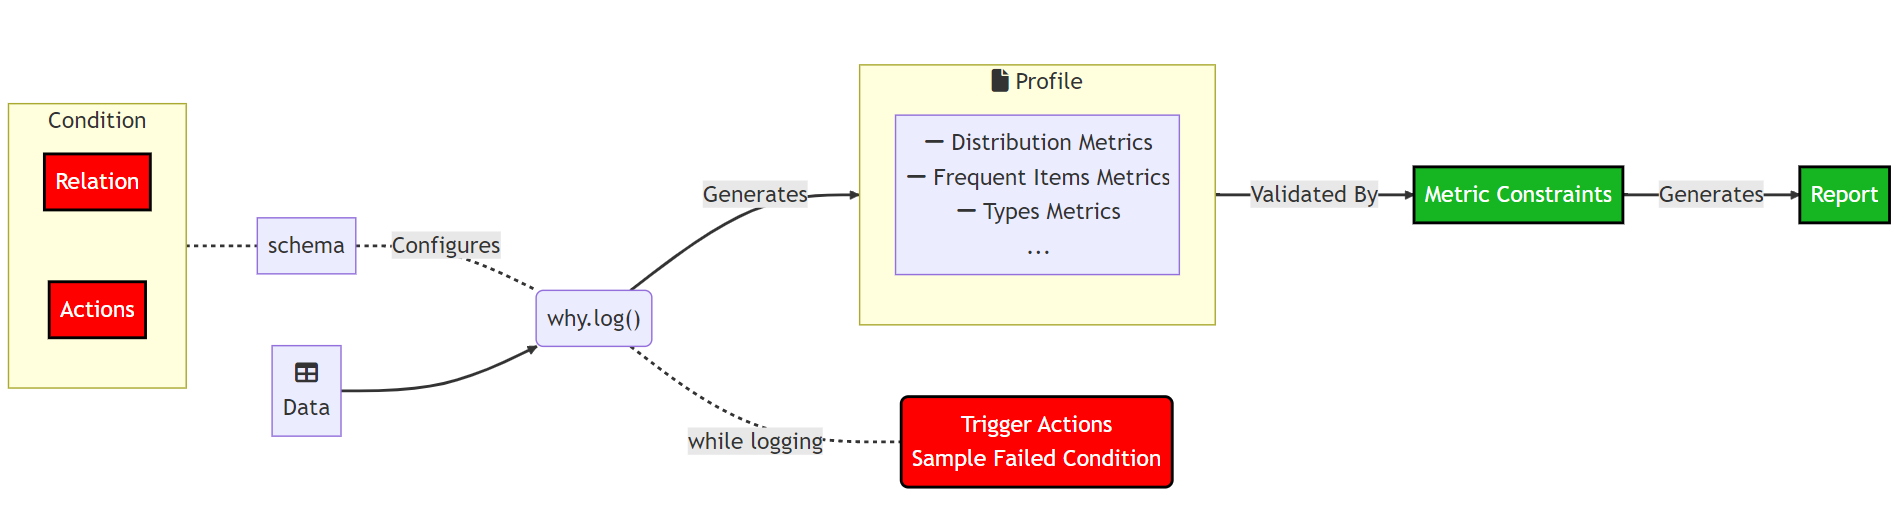

> Note: Actions can also be executed using __Conditions__. In upcoming releases, our goal is to unify all the functionalities introduced in Sessions 4 and 5 within the Conditions framework.

### Defining the Actions

The action to be triggered when a contidion fails is created by simply defining a regular function.

We should just remember to define the arguments: `validator_name`, `condition_name` and `value`. You can use these values to help with logging and debugging the failures.

In [22]:
from typing import Any

def halt_pipeline(validator_name, condition_name: str, value: Any):
    print("Validator: {}\n    Condition name {} failed for value {}".format(validator_name, condition_name, value))
    print("    Halting the pipeline....")
    # Do something here to respond to the constraint violation
    return

def send_slack_alert(validator_name, condition_name: str, value: Any):
    print("Validator: {}\n    Condition name {} failed for value {}".format(validator_name, condition_name, value))
    print("    Sending slack alert....")
    # Do something here to respond to the constraint violation
    return

To create a Condition Validator, we need a name, a set of conditions, and a list of actions.

Let's make a Validator for the date format validator and another Validator for the url validation. Each validator has a single condition to be evaluated, and also a single action.


In [23]:
from whylogs.core.validators import ConditionValidator


date_format_validator = ConditionValidator(
    name="date_format_validation",
    conditions=last_review_conditions,
    actions=[send_slack_alert],
)

url_validator = ConditionValidator(
    name="domain_regex_validation",
    conditions=listing_url_conditions,
    actions=[halt_pipeline],
)

validators = {
    "last_review": [date_format_validator],
    "listing_url": [url_validator]}

Now we're set to log our data. We'll use the same schema as before, but this time we'll pass our validators to the `log` method.

In [24]:
from whylogs.core.schema import DatasetSchema
import whylogs as why

schema = DatasetSchema(validators=validators)
profile = why.log(df_target, schema=schema).profile()

Validator: domain_regex_validation
    Condition name url_matches_airbnb_domain failed for value www.airbnb.com/rooms/47105367
    Halting the pipeline....
Validator: domain_regex_validation
    Condition name url_matches_airbnb_domain failed for value www.airbnb.com/rooms/18893176
    Halting the pipeline....
Validator: domain_regex_validation
    Condition name url_matches_airbnb_domain failed for value www.airbnb.com/rooms/38630639
    Halting the pipeline....
Validator: domain_regex_validation
    Condition name url_matches_airbnb_domain failed for value www.airbnb.com/rooms/45593569
    Halting the pipeline....
Validator: domain_regex_validation
    Condition name url_matches_airbnb_domain failed for value www.airbnb.com/rooms/26165233
    Halting the pipeline....
Validator: domain_regex_validation
    Condition name url_matches_airbnb_domain failed for value www.airbnb.com/rooms/41730820
    Halting the pipeline....
Validator: domain_regex_validation
    Condition name url_matche

You can see that the validators are being triggered when the conditions fail. The validators will also retain a sample of the data that failed the conditions. We can access that data by calling `get_samples` on the validator.

Additionally, if you call `to_summary_dict` on the validator, you'll get a summary of the validator's status, as well as the number of times the conditions were evaluated, and the number of times the conditions failed.

In [25]:
print(url_validator.to_summary_dict())
url_validator.get_samples()

{'total_evaluations': 5422, 'url_matches_airbnb_domain': 30}


['www.airbnb.com/rooms/13327744',
 'www.airbnb.com/rooms/45593569',
 'www.airbnb.com/rooms/46437836',
 'www.airbnb.com/rooms/41730820',
 'www.airbnb.com/rooms/22596125',
 'www.airbnb.com/rooms/772144',
 'www.airbnb.com/rooms/22613087',
 'www.airbnb.com/rooms/18893176',
 'www.airbnb.com/rooms/10837127',
 'www.airbnb.com/rooms/13553340']

In [26]:
print(date_format_validator.to_summary_dict())
date_format_validator.get_samples()

{'total_evaluations': 5422, 'is_date_format': 2}


['2020/12/31', '27-02-2020']